[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **Environmental space definition for global hydrogen production**
<!-- **<div style="text-align: left; font-size: 19px;"> Environmental space definition for global hydrogen production**</div> -->

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Division for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>

<div style="text-align: left; font-size: 13px;"> Code developer and maintainer:<a href="mailto:m.lejeune@unsw.edu.au"> Michaël Lejeune</div></a><br>


# **0. Initialisation**

In [1]:
using CSV,DataFrames,XLSX,Statistics, Interpolations
using LinearAlgebra,SparseArrays, Distributions, KernelDensity
using JLD2
import Statistics: quantile
using Logging

global_logger(NullLogger())
include("Utils/2_02_utils.jl");

xr = pyimport("xarray");

function quantile(a::Matrix{Float64}, q::Float64; dims::Int64)
    return mapslices(x -> quantile(x, q), a; dims=dims) |> vec
end


Reading AR6 scenarios...
Reading remind scenarios...
Reading IMAGE SSP2-1.9 scenarios...
Reading IMAGE SSP2-1.9new scenarios...
Reading...
past...
Reading tiam-ucl scenarios...


quantile (generic function with 81 methods)

In [32]:
respath="./Source data/02_results/Fig2/"
if !isdir(respath)
    mkdir(respath)
end


## **0.1 Scenario ensemble initialisation**

```python

In [3]:
### Target setting
target=2.25#2.25 #max W/m² by 2100

## We make this initial filter based on the AR6 report - A.III.I.11 Comparison of Mitigation and Removal Measures Represented by Models that Contributed Mitigation Scenarios to the Assessment - Table 7 | Overview of demand- and supply-side mitigation and removal measures in the energy, transport, building, industry and AFOLU sectors, as stated by contributing modelling teams to the AR6 database.

## models with a comprhensive hydrogen production pathways (explicit and endogenous):
accepted_mods=["REMIND","MESSAGEix-GLOBIOM","POLES",
            "IMAGE","PROMETHEUS","TIAM","REmap",
            "COFFEE","EPPA","McKinsey","GCAM","GMM"]

## rejected scenarios based on insufficient data granularity.
rejected_scenarios=["EMF33",
                    "CD-LINKS",
                    "SSP1-19",
                    "SSP2-19",
                    "SSP5-19",
                    "R_MAC_35_n8",
                    "R_MAC_30_n8",
                    "EN_NPi2020_200f",
                    "EN_NPi2020_300f",
                    "EN_NPi2020_400f",
                    "SSP2_openres_lc_120",
                    "SSP2_openres_lc_CB400",
                    "SSP2_openres_lc_CB450",
                    "SSP2_openres_lc_CB500",
                    "SSP2_openres_lc_CB550",
                    "SSP2_openres_lc_CB600",
                    "EMF30_ClimPolicy",
                    "EMF30_ClimPolicy+SLCF",
                    "EMF30_Slower-to-faster",
                    "EMF30_Slower-to-faster+SLCF",
                    "EMF30_Slower-to-faster+SLCF+HFC"]

df = AR6database_formating(target; accepted_models=accepted_mods, rejected_scenarios=rejected_scenarios);


In [5]:
rmd_df=filter(s -> s[:Scenario] == "SSP1-PkBudg500" ||
                    s[:Scenario] == "SSP2EU-PkBudg500" ||
                    s[:Scenario] == "SSP5-PkBudg500",df);


In [ ]:
df_h2=filter(row -> row[:Scenario] != "ADVANCE_2020_1.5C-2100" && row[:Scenario] != "ADVANCE_2030_1.5C-2100" && row[:Model] !="POLES ADVANCE" && row[:Model] != "REMIND", df);


# **1. Future hydrogen production**

In [7]:
ṁᴹᵗref=getVals("Secondary Energy|Hydrogen",df=df_h2,years=2025:5:2050).*(1e18 / 120e6) / 1e9;


In [8]:
ṁᴹᵗ=(
    #getVals("Secondary Energy|Hydrogen|Fossil|w/o CCS",df=df_h2,years=2025:5:2050).+
    getVals("Secondary Energy|Hydrogen|Fossil|w/ CCS",df=df_h2,years=2025:5:2050).+
    getVals("Secondary Energy|Hydrogen|Biomass|w/o CCS",df=df_h2,years=2025:5:2050).+
    getVals("Secondary Energy|Hydrogen|Biomass|w/ CCS",df=df_h2,years=2025:5:2050).+
    getVals("Secondary Energy|Hydrogen|Electricity",df=df_h2,years=2025:5:2050)
    ).*(1e18 / 120e6) / 1e9

ṁᴹᵗq05=quantile(ṁᴹᵗ,0.05,dims=1)'
ṁᴹᵗq25=quantile(ṁᴹᵗ,0.25,dims=1)'
ṁᴹᵗq50=median(ṁᴹᵗ,dims=1)'
ṁᴹᵗq50ref=median(ṁᴹᵗref,dims=1)'
ṁᴹᵗq75=quantile(ṁᴹᵗ,0.75,dims=1)'
ṁᴹᵗq95=quantile(ṁᴹᵗ,0.95,dims=1)';


# **2. Utilitarian allocation factor for hydrogen production**


In [9]:
Emi=getVals("Emissions|CO2|Gross",df=df_h2);
Emiˢᵉ=getVals("Emissions|CO2|Gross|Energy|Supply",df=df_h2);
SE=getVals("Secondary Energy",df=df_h2)
SEʰ²=getVals("Secondary Energy|Hydrogen",df=df_h2)
ṁᴹᵗref_full=getVals("Secondary Energy|Hydrogen",df=df_h2).*(1e18 / 120e6) / 1e9; #full years from 2020 to 2100


In [10]:
αᵉᵐⁱ=Emiˢᵉ./Emi;


In [11]:

ṁᵏᵍ=ṁᴹᵗref_full.*1e9; # convert to kg
ṁᴳᵗ=ṁᴹᵗref_full.*1e-3; # convert to Gg
αˢᵉ=SEʰ²./SE;
α=αᵉᵐⁱ.*αˢᵉ
αᵏᵍ=α./ṁᵏᵍ;
αᴹᵗ=α./ṁᴹᵗref_full;
αᴳᵗ=α./ṁᴳᵗ;


# **3. Climate change scenario variables**

## **3.1. Data gathering**

In [12]:
fair_ds = xr.open_dataset("./Source data/01_input/FAIR/climate_data.nc")

GSTA_fair=fair_ds.GSTA.median(dim="config").sel(layer=0,scenario="ssp119",timebounds=(2015:1:2105).-1)
GSTA_fair_10yr_avg = GSTA_fair.rolling(timebounds=50, center=true).mean()
EFR_fair= fair_ds.ERF.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1)
EFR_CO2_fair= fair_ds.CO2_erf.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1)
atCO2_fair= fair_ds.atco2.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1);


In [13]:
## Data from the Annex III of the Intergovernmental Panel On Climate Change (Ipcc) (2023) Climate Change 2021 – The Physical Science Basis: Working Group I Contribution to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change. 1st edn. Cambridge University Press. Available at: https://doi.org/10.1017/9781009157896.
hist_years_erf =[1750, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2015, 2019]
hist_years_ppm = [
    1750, 1850, 1860, 1870, 1880, 1890, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935,
    1940, 1945, 1950, 1955, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
    1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
    2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019
]
ssp19_years2500 = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2200, 2300, 2400, 2500]
ssp19_years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

hist_ppm = [
    278.3, 285.5, 286.8, 288.4, 290.4, 293.3, 296.4, 298.0, 300.0, 302.5, 304.8, 306.3, 307.1, 308.6,
    311.7, 312.7, 313.1, 314.6, 316.8, 317.5, 318.2, 318.8, 319.5, 320.0, 321.0, 321.6,
    358.2, 360.0, 361.8, 362.5, 365.5, 367.6, 368.8, 370.4, 372.4, 375.0, 376.8, 378.8,
    381.0, 382.7, 384.8, 386.3, 388.6, 390.5, 392.5, 395.2, 397.1, 399.4, 402.9, 405.0, 407.4, 409.9
]
ssp19_ppm2500 =   [414,  434,  440,  438,  431,  424,  415,  405,  394,  343,  342,  339,  337]
ssp19_ppm =   [414,  434,  440,  438,  431,  424,  415,  405,  394]
ssp126_ppm = [414, 440, 458, 469, 474, 473, 467, 457, 446, 403, 396, 389, 384]

hist_erf = [0.3, 0.33, 0.34 ,.3, 0.43, 0.48, 0.52, 0.59, 0.54, 0.42, 0.86, 1.42, 2.02, 2.23, 2.61, 2.84]
ssp19_erf = [2.81, 3.20, 3.18, 3.05, 2.88, 2.76, 2.64, 2.48, 2.33, 1.58, 1.49, 1.42, 1.38]
ssp26_erf = [2.80, 3.21, 3.48, 3.58, 3.58, 3.54, 3.42, 3.25, 3.10, 2.50, 2.30, 2.19, 2.11];
ssp19_erfCO2 =   [2.22,2.49,2.56,2.53,2.45,2.35,2.23,2.09,1.92];


In [14]:
GSTA=getVals("AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile",df=df_h2)
RF=getVals("AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|50.0th Percentile",df=df_h2);
GSTA_rmd=getVals("Temperature|Global Mean",df=rmd_df);
Emi_rmd=getVals("Emissions|CO2",df=rmd_df).*1e9;



In [15]:
∑=sum
function decay_matrix(;period=2020:1:2101)
    period=period.-2019
    α₀ = 0.2173
    α = [0.2240, 0.2824, 0.2763]
    τ = [394.4, 36.54, 4.304]
    IRF_CO₂(t)= α₀*t + ∑([αᵢ * τᵢ * (1 - exp(-t/ τᵢ)) for (αᵢ, τᵢ) in zip(α, τ)])
    ∂IRF_CO₂ = diff(IRF_CO₂.(period)) #reduction of 1 year here 80
    
    t=length(period)-1
    
    matrix=zeros(t,t)
    
    for y ∈ 1:1:t
        matrix[y,y:t]=∂IRF_CO₂[1:t-y+1]
    end
    return matrix
end

function equation2(;period=2020:1:2101)
    Mᶜᵒ² = 44.01e-3  # kg mol⁻¹
    Mᵃⁱʳ = 28.97e-3   # mean molar mass of air in kg mol⁻¹
    mᵃᵗᵐ = 5.148e18   # 5.135e18 #total mass of Earth’s atmosphere in kg
    qₛ = (Mᵃⁱʳ / mᵃᵗᵐ) * 1e9 #air mixing ratio ppb mol⁻¹
    decays_concentration = (qₛ/Mᶜᵒ²) .* decay_matrix(period=period).*1e-3 # in ppm kg⁻¹
    return  decays_concentration
end

function equation3(;period=2020:1:2101)
    εᶜᵒ² = 1.33e-2 # W/m2/ppm; concentration; IPCC AR6 Table 7.15
    return  decays_forcing=εᶜᵒ².*equation2(;period=period) #  W m⁻² kg⁻¹
end


equation3 (generic function with 1 method)

In [16]:
decay_ppm=equation2()
decay_rf=equation3();


In [17]:
Emi=getVals("Emissions|CO2",df=df).*1e9
years=2021:1:2100
period=years.-2020

## CO2 cocnentration
decay_concentration=vcat([∑(decay_ppm.*Emi[ssp,:],dims=1) for ssp ∈ 1:size(Emi,1)]...).+409.9
decay_concentration_rmd=vcat([∑(decay_ppm.*Emi_rmd[ssp,:],dims=1) for ssp ∈ 1:3]...).+409.9


decay_concentration05=quantile(decay_concentration,0.05,dims=1)
decay_concentration25=quantile(decay_concentration,0.25,dims=1)
decay_concentration50=quantile(decay_concentration,0.5,dims=1)
decay_concentration75=quantile(decay_concentration,0.75,dims=1)
decay_concentration95=quantile(decay_concentration,0.95,dims=1);

decay_concentration05_rmd=quantile(decay_concentration_rmd,0.05,dims=1)
decay_concentration25_rmd=quantile(decay_concentration_rmd,0.25,dims=1)
decay_concentration50_rmd=quantile(decay_concentration_rmd,0.5,dims=1)
decay_concentration75_rmd=quantile(decay_concentration_rmd,0.75,dims=1)
decay_concentration95_rmd=quantile(decay_concentration_rmd,0.95,dims=1);

## Radiative forcing
decayforcing=vcat([∑(decay_rf.*Emi[ssp,:],dims=1) for ssp ∈ 1:size(Emi,1)]...).+2.16
decayforcing_rmd=vcat([∑(decay_rf.*Emi_rmd[ssp,:],dims=1) for ssp ∈ 1:3]...).+2.16

decayforcing05=quantile(decayforcing,0.05,dims=1)
decayforcing25=quantile(decayforcing,0.25,dims=1)
decayforcing50=quantile(decayforcing,0.5,dims=1)
decayforcing75=quantile(decayforcing,0.75,dims=1)
decayforcing95=quantile(decayforcing,0.95,dims=1);

decayforcing05_rmd=quantile(decayforcing_rmd,0.05,dims=1)
decayforcing25_rmd=quantile(decayforcing_rmd,0.25,dims=1)
decayforcing50_rmd=quantile(decayforcing_rmd,0.5,dims=1)
decayforcing75_rmd=quantile(decayforcing_rmd,0.75,dims=1)
decayforcing95_rmd=quantile(decayforcing_rmd,0.95,dims=1);


In [18]:
############ Global Surface Air Temperature Anomaly (GSTA) ############
TA=fair_ds.GSTA.sel(scenario="ssp119",layer=0)
TA26=fair_ds.GSTA.sel(scenario="ssp126",layer=0)
TAq05=TA.quantile(0.05, dim="config")
TAq16=TA.quantile(0.16, dim="config")
TAq84=TA.quantile(0.84, dim="config")
TAq95=TA.quantile(0.95, dim="config")
TAq50=TA.median(axis=1)
TAq50ssp126=TA26.median(axis=1)
TAmin=TA.min(dim="config")
TAmax=TA.max(dim="config")

############ Atmospheric CO2 concentration ############
CO2_conc=fair_ds.atco2.sel(scenario="ssp119")
CO2_conc26=fair_ds.atco2.sel(scenario="ssp126")
CO2_concq05=CO2_conc.quantile(0.05, dim="config")
CO2_concq16=CO2_conc.quantile(0.16, dim="config")
CO2_concq84=CO2_conc.quantile(0.84, dim="config")
CO2_concq95=CO2_conc.quantile(0.95, dim="config")
CO2_concq50=CO2_conc.median(axis=1)
CO2_concq50ssp126=CO2_conc26.median(axis=1)
CO2_concmin=CO2_conc.min(dim="config")
CO2_concmax=CO2_conc.max(dim="config")
period=fair_ds.timebounds

############ Effective Radiative Forcing (ERF) ############
ERF=fair_ds.ERF.sel(scenario="ssp119")
ERF26=fair_ds.ERF.sel(scenario="ssp126")
ERFq05=ERF.quantile(0.05, dim="config")
ERFq16=ERF.quantile(0.16, dim="config")
ERFq84=ERF.quantile(0.84, dim="config")
ERFq95=ERF.quantile(0.95, dim="config")
ERFq50=ERF.median(axis=1)
ERFq50ssp126=ERF26.median(axis=1)
ERFmin=ERF.min(dim="config")
ERFmax=ERF.max(dim="config");


## **3.2. Ensemble validations: Supplementary Fig.17**

In [19]:
erf_fairCO2=fair_ds.CO2_erf.sel(scenario="ssp119",timebounds=(2020:1:2100))
EFR_CO2_fairq05=erf_fairCO2.quantile(0.05, dim="config")
EFR_CO2_fairq95=erf_fairCO2.quantile(0.95, dim="config")
times=EFR_CO2_fairq95.timebounds;
co2_df = CSV.read("./Source data/01_input/CO2 data/co2.csv", DataFrame);


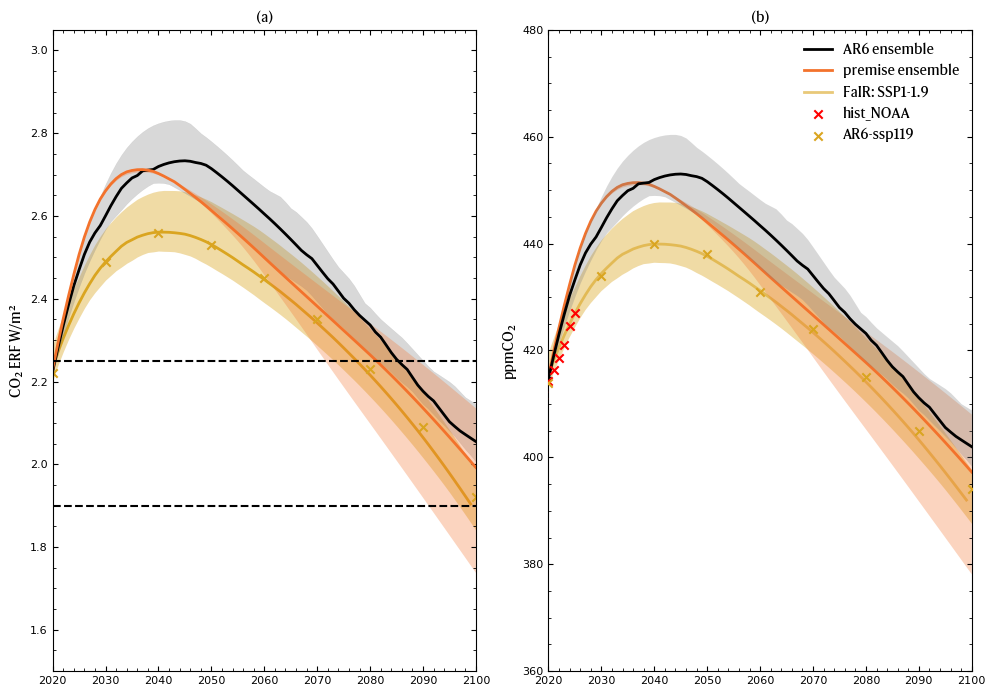

In [20]:
fig, axs = plt.subplots(1, 2,figsize=(10, 7))
years = 2020:1:2100
year_index= years.-2019
# fig a
    axs[1].plot(years,decayforcing50',color="k",label="AR6 ensemble", lw=2)
    EFR_CO2_fair.plot(ax=axs[1],x="timebounds", color="goldenrod", label="FaIR: SSP1-1.9",zorder=0, lw=2)
    axs[1].fill_between(EFR_CO2_fairq95.timebounds,EFR_CO2_fairq05,EFR_CO2_fairq95,color="goldenrod",alpha=0.4,lw=0)
    axs[1].fill_between(years,decayforcing25,decayforcing75,color="grey",alpha=0.3, lw=0.2)

    axs[1].plot(years,median(decayforcing_rmd[1:3,:],dims=1)',label="premise ensemble", lw=2)
    axs[1].fill_between(years,decayforcing25_rmd,decayforcing75_rmd,alpha=0.3, lw=0.2)

    axs[1].scatter(ssp19_years,ssp19_erfCO2,color="goldenrod",marker="x")
    axs[1].set_ylabel("CO₂ ERF W/m²", fontproperties=font_prop_labels)
    axs[1].axhline(2.25,color="black",linestyle="--",xmax=1)
    axs[1].set_xlim(2020, 2100)
    axs[1].set_ylim(1.5, 3.05)
    axs[1].set_xlabel("")
    axs[1].set_title("(a)", fontproperties=font_prop)
    axs[1].axhline([1.9],color="black",linestyle="--",xmax=1)
#end fig a

# fig b
    axs[2].plot(years,decay_concentration50', color="k",label="AR6 ensemble", lw=2,zorder=5)
    axs[2].plot(years,median(decay_concentration_rmd[1:3,:],dims=1)',label="premise ensemble", lw=2)
    

    atCO2_fair.plot(ax=axs[2],x="timebounds", color="goldenrod", label="FaIR: SSP1-1.9",zorder=0, lw=2,alpha=0.6)
    axs[2].scatter(co2_df.year, co2_df.co2_ppm,marker="x",color="red", label="hist_NOAA",zorder=5)
    axs[2].scatter(ssp19_years,ssp19_ppm,color="goldenrod",marker="x",zorder=5,label="AR6-ssp119")

    axs[2].fill_between(x=years, y1=decay_concentration25, y2=decay_concentration75, color="grey",alpha=0.3, linewidth=0,zorder=4)
    axs[2].fill_between(years,decay_concentration25_rmd,decay_concentration75_rmd,alpha=0.3, lw=0.2)
    axs[2].fill_between(period, CO2_concq05, CO2_concq95, alpha=0.4, color="goldenrod",linewidth=0,zorder=0)

   

    axs[2].set_title("(b)", fontproperties=font_prop)
    axs[2].set_xlabel("")
    axs[2].set_ylabel("ppmCO₂", fontproperties=font_prop_labels)
    axs[2].legend(frameon=false,prop=font_prop_labels)
    axs[2].set_xlim(2020, 2100)
    axs[2].set_ylim(360, 480)
# end fig b



fig.tight_layout()
fig.savefig(respath*"scenario_climate_vars.svg", bbox_inches="tight",transparent=true)
fig.savefig(respath*"scenario_climate_vars.png", dpi=800 ,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


## **3.4. Fig.2**

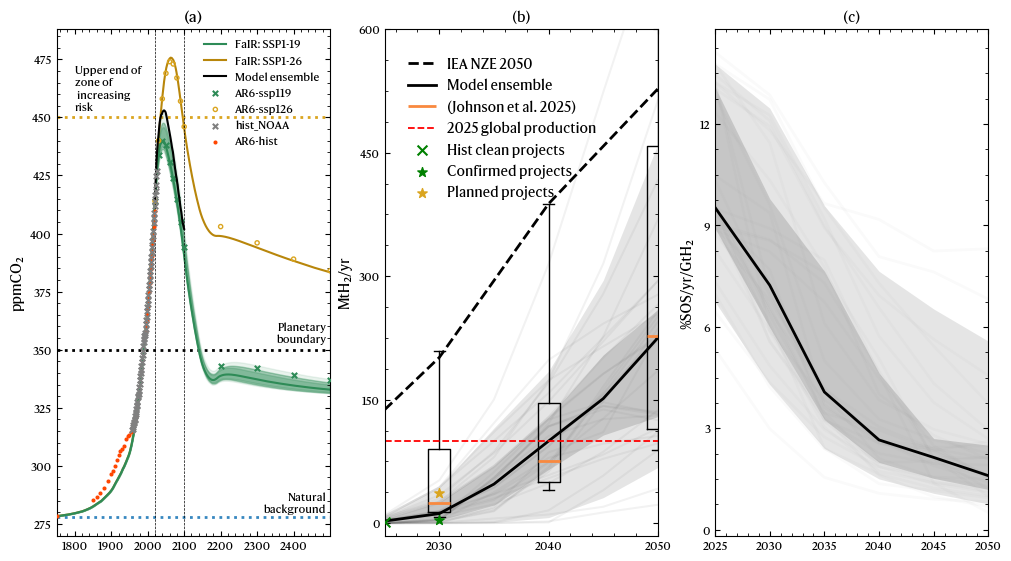

In [21]:
box_stats = [ #data from Johnson et al. 2025
    Dict(
        "med" => 25,
        "q1" => 13.5,
        "q3" => 90,
        "whislo" => 7.7,
        "whishi" => 208.7,
    ),Dict(
        "med" => 75,
        "q1" => 49.6,
        "q3" => 146,
        "whislo" => 40.4,
        "whishi" => 388,
    ),Dict(
        "med" => 227.583,
        "q1" => 114.680,
        "q3" => 458.337,
        "whislo" => 89.328,
        "whishi" => 659.332,
    )
]

A,B,C = plt.figure(figsize=(10, 5.5),facecolor="none",layout="constrained").subplot_mosaic(
                                        "ABC",
                                        width_ratios=[1,1,1])
axs=[B,A,C]
axs=[i[2] for i in axs]
years=2025:5:2050
year_index=years.-2019 

#(a) CO2 concentration
bluee=(0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0)
CO2_concq50.plot(ax=axs[1], label="FaIR: SSP1-19", color="seagreen")
CO2_concq50ssp126.plot(ax=axs[1], label="FaIR: SSP1-26", color="darkgoldenrod",zorder=0)
axs[1].plot(2020:1:2100,decay_concentration50', color="k",label="Model ensemble",zorder=5)
axs[1].set_title("(a)",fontproperties=font_prop_titles)
axs[1].fill_between(period, CO2_concmin, CO2_concmax, alpha=0.1, color="seagreen")
axs[1].fill_between(period, CO2_concq05, CO2_concq95, alpha=0.4, color="seagreen")
axs[1].fill_between(period, CO2_concq16, CO2_concq84, alpha=0.25, color="seagreen")
axs[1].scatter(ssp19_years2500, ssp19_ppm2500,marker="x",color="seagreen", label="AR6-ssp119",zorder=3,s=15)
axs[1].scatter(ssp19_years2500, ssp126_ppm,marker=".",edgecolor="goldenrod",color="none", label="AR6-ssp126",zorder=3)
axs[1].scatter(co2_df.year, co2_df.co2_ppm,marker="x",color="grey", label="hist_NOAA",zorder=5,s=15)
axs[1].scatter(hist_years_ppm, hist_ppm,marker=".",color="orangered", label="AR6-hist",zorder=3,s=15)
axs[1].axhline(350, ls=":", color="k",linewidth=2,zorder=0)
axs[1].axhline(278, ls=":",color="#3787c0",linewidth=2,zorder=0)
axs[1].axhline(450, ls=":", color="goldenrod",linewidth=2,zorder=0)
axs[1].set_xlim(period[1], period[-1])
axs[1].set_ylim(270, 488)
axs[1].set_ylabel("ppmCO₂",fontproperties=font_prop_labels)
axs[1].set_xlabel("")
axs[1].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[1].axvline(2020, ls="--", color="k", linewidth=0.5)
axs[1].annotate("Upper end of\nzone of\n increasing\nrisk", xy=(1800, 453), xytext=(1800, 453), fontproperties=font_prop_ticks,ha="left")
axs[1].annotate("Planetary\nboundary", xy=(2490, 353), xytext=(2490, 353), fontsize=8, fontproperties=font_prop_ticks,ha="right")
axs[1].annotate("Natural\nbackground", xy=(2490, 280), xytext=(2490, 280), fontsize=8, fontproperties=font_prop_ticks,ha="right")
axs[1].legend(loc="upper right",frameon=false,prop=font_prop_ticks)#


#(b) Global hydrogen production
IEA_years=[2025,2030,2035,2040,2045,2050]
IEA_vals=[137.841672,201.3247223,294.6324469,387.955364,457.7382688, 527.5227996]#.*EJH2_to_kgH2*1.e-9
axs[2].plot(IEA_years,IEA_vals,label="IEA NZE 2050",color="k",linestyle="--",lw=2)
axs[2].plot(years,ṁᴹᵗq50,color="k",label="Model ensemble",lw=2)
axs[2].plot(years, ṁᴹᵗ',color="k",alpha=0.05,zorder=0)
axs[2].set_ylabel("MtH₂/yr", fontproperties=font_prop)
axs[2].fill_between(x=years, y1=ṁᴹᵗq05, y2=ṁᴹᵗq95, color="grey",linewidth=0, alpha=0.2)
axs[2].fill_between(x=years, y1=ṁᴹᵗq25, y2=ṁᴹᵗq75, color="grey",linewidth=0, alpha=0.3)
axs[2].set_title("(b)", fontproperties=font_prop)
axs[2].bxp(box_stats,positions=[2030,2040,2050], showfliers=false,label="(Johnson et al. 2025)",widths=2,medianprops=Dict("linewidth"=>2))
axs[2].axhline(100, color="red",linestyle="--",linewidth=1.3,label="2025 global production")
axs[2].scatter([2025],[0.95],zorder=5,marker="x",color="green",s=50,label="Hist clean projects")
axs[2].scatter([2030],[4],zorder=5,marker="*",color="green",s=50,label="Confirmed projects")
axs[2].scatter([2030],[37],zorder=5,marker="*",color="goldenrod",s=50,label="Planned projects")
# axs[2].scatter([2030,2035,2040],[86,109,121],zorder=5,marker=".",color="red",s=50,label="planned+concept")

axs[2].set_ylim(-15, 600)
axs[2].set_xlim(2025, 2050)
axs[2].yaxis.set_major_locator(tkr.MaxNLocator(integer=true, nbins=5))
handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels, frameon=false, loc="upper center", bbox_to_anchor=(0.43, 0.97), ncol=1, prop=font_prop)
for ax in axs
    for ticklabel in ax.get_xticklabels()
        ticklabel.set_fontproperties(font_prop_ticks)
        end

    for ticklabel in ax.get_yticklabels()
        ticklabel.set_fontproperties(font_prop_ticks)
    end
end


#(c) environmental space per GtH2
axs[3].set_title("(c)",fontproperties=font_prop_labels)
αᵏᵍmins = [minimum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αᵏᵍmaxs = [maximum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αq(a,q) = [quantile(filter(!isnan, a[:,j]), q ) for j in 1:size(a,2)][year_index]

αᵏᵍq05 , αᵏᵍq95 = αq(αᵏᵍ,0.05),αq(αᵏᵍ,0.95) #5-95th (90%) IQR 
αᵏᵍq25 , αᵏᵍq75 = αq(αᵏᵍ,0.25),αq(αᵏᵍ,0.75) #25-75th (50%) IQR
αᵏᵍq50 = αq(αᵏᵍ,0.50)
αᴳᵗq05, αᴳᵗq95 = αq(αᴳᵗ,0.05),αq(αᴳᵗ,0.95) #5-95th (90%) IQR
αᴳᵗq25 , αᴳᵗq75 = αq(αᴳᵗ,0.25),αq(αᴳᵗ,0.75) #25-75th (50%) IQR
αᴳᵗq50 = αq(αᴳᵗ,0.50)

axs[3].plot(years,αᴳᵗ[:,year_index]'.*100,linewidth=2,color="grey",alpha=0.04,zorder=0,label="PkBudg")
axs[3].plot(years,αᴳᵗq50 .*100 ,label="Median",linewidth=2, color="k")
axs[3].fill_between(x=years, y1=αᴳᵗq05.*100, y2=αᴳᵗq95.*100, color="grey",linewidth=0, alpha=0.2) #85% proba
axs[3].fill_between(x=years, y1=αᴳᵗq25.*100, y2=αᴳᵗq75.*100, color="grey",linewidth=0, alpha=0.3) #70% proba
axs[3].set_xlim(2025, 2050)
axs[3].set_ylabel("%SOS/yr/GtH₂",fontproperties=font_prop_labels)
axs[3].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))


plt.savefig(respath*"fig2.svg", bbox_inches="tight",transparent=true)
plt.savefig(respath*"fig2.png", dpi=800,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


# **4. Allocated safe operating space**

First we load the safe operating space.

In [22]:
sos=load("./Source data/02_results/data_SOS.jld2")
𝚫𝐗ᴾᵇ,𝚫𝐗ᴰ,units,catnames=sos["𝚫𝐗ᴾᵇ"],sos["𝚫𝐗ᴰ"],sos["units"],sos["control_var"];


In [23]:
## First we need to create a set of years that fit the dimension of our assessment. 
all_years = 2020:1:2100
assessment_years = 2025:5:2050
years_to_remove=setdiff(all_years,assessment_years)
years=setdiff(all_years,years_to_remove);


$$
\boldsymbol{\omega^{b}} = \alpha \times \boldsymbol{\Delta X^{b}} \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$


When this is done, we need to broadcast these vectors into matrices to fit the dimensions of our study. We have 3 scenarios and 6 years. To respect the convention used in this work

$$
\boldsymbol{\Omega^{b}_{yq} = \alpha_{yq} \times \Delta X^{b}}  \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$

We can now perform the allocation of the safe operating space and save our results.

In [24]:
𝚨max=maximum(αᵏᵍ[:,years.-2019],dims=1)
𝚨min=minimum(αᵏᵍ[:,years.-2019],dims=1)
𝚨q50=median(αᵏᵍ[:,years.-2019],dims=1)
δ𝛀ᴾᵇ=𝚫𝐗ᴾᵇ.*TriangularDist.(𝚨min, 𝚨max, 𝚨q50);
𝛀ᴾᵇ=𝚫𝐗ᴾᵇ*mode.(TriangularDist.(𝚨min, 𝚨max, 𝚨q50))
δ𝛀ᴰ=𝚫𝐗ᴰ.*TriangularDist.(𝚨min, 𝚨max, 𝚨q50);
𝛀ᴰ=𝚫𝐗ᴰ*mode.(TriangularDist.(𝚨min, 𝚨max, 𝚨q50));


# **5.Result export**


In [25]:
@save respath*"aSOS.jld" 𝛀ᴾᵇ δ𝛀ᴾᵇ 𝛀ᴰ δ𝛀ᴰ
@save respath*"ensemble.jld" df_h2


In [26]:
if isfile(respath*"ensemble.xlsx")
    rm(respath*"ensemble.xlsx")
    # writetable(df_h2,workbook=respath*"ensemble.xlsx") #full scenario variables cannot be shared.
    writetable(getModel(df_h2); worksheet="ensemble data", workbook=respath*"ensemble.xlsx")
else    
    # writetable(df_h2,workbook=respath*"ensemble.xlsx") #full scenario variables cannot be shared.
    writetable(getModel(df_h2); worksheet="ensemble data", workbook=respath*"ensemble.xlsx") 
end


## **Fig2a**

In [27]:
co2_resdf=DataFrame(hcat([(2020:1:2100),decay_concentration05,decay_concentration50,decay_concentration95]...),
            [:Year;:CO2_ppm_05; :CO2_ppm_50; :CO2_ppm_95])

rmd_res=hcat((2020:1:2100),quantile(decay_concentration_rmd[1:3,:],0.05,dims=1),median(decay_concentration_rmd[1:3,:],dims=1)',quantile(decay_concentration_rmd[1:3,:],0.95,dims=1))

co2_resdf_premise=DataFrame(rmd_res,[:Year;:CO2_ppm_05;:CO2_ppm_50;:CO2_ppm_95])

FaIRdf=DataFrame(hcat(CO2_conc.timebounds.values,CO2_conc.quantile(0.05, dim="config").values,CO2_conc.median(axis=1).values,CO2_conc.quantile(0.95, dim="config").values),
            [:Year;:CO2_ppm_05; :CO2_ppm_50; :CO2_ppm_95])

if isfile(respath*"Fig2a.xlsx")
    rm(respath*"Fig2a.xlsx")
end
writetable(co2_resdf; worksheet="AR6_ensemble", workbook=respath*"Fig2a.xlsx")
writetable(co2_resdf_premise; worksheet="premise_ensemble", workbook=respath*"Fig2a.xlsx")
writetable(co2_df; worksheet="NOAA", workbook=respath*"Fig2a.xlsx")
writetable(FaIRdf; worksheet="FaIR", workbook=respath*"Fig2a.xlsx")


## **Fig2b**

In [28]:
h2prodddf=DataFrame(hcat(2025:5:2050,ṁᴹᵗq05',ṁᴹᵗq25',ṁᴹᵗq50,ṁᴹᵗq75',ṁᴹᵗq95'),
            [:Year;:H2_Mt_05; :H2_Mt_25; :H2_Mt_50; :H2_Mt_75; :H2_Mt_95]) 

function CAGR(v0,v1; y=25)
    cagr = (v1 / v0)^(1 / y) - 1
    return cagr
end

h2cagr=hcat([[CAGR(o[1],i,y=b)*100 for (i,b) in zip(o[1:end],[0,5,10,15,20,25])] for o in [ṁᴹᵗq05',ṁᴹᵗq25',ṁᴹᵗq50,ṁᴹᵗq75',ṁᴹᵗq95']]...)
h2cagrdf=DataFrame(hcat(2025:5:2050,h2cagr),
            [:Year;:H2_CAGR_05; :H2_CAGR_25; :H2_CAGR_50; :H2_CAGR_75; :H2_CAGR_95])
if isfile(respath*"Fig2b.xlsx")
    rm(respath*"Fig2b.xlsx")
end         
writetable(h2prodddf; worksheet="hydrogen production", workbook=respath*"Fig2b.xlsx")
writetable(h2cagrdf; worksheet="hydrogen CAGR", workbook=respath*"Fig2b.xlsx")


## **Fig2c**

In [29]:
asosdf=DataFrame(hcat(years,hcat(αᴳᵗq05,αᴳᵗq25,αᴳᵗq50,αᴳᵗq75,αᴳᵗq95).*100),
            [:Year;:SOS_per_GtH2_05; :SOS_per_GtH2_25; :SOS_per_GtH2_50; :SOS_per_GtH2_75; :SOS_per_GtH2_95])
if isfile(respath*"Fig2c.xlsx")
    rm(respath*"Fig2c.xlsx")
end
writetable(asosdf; worksheet="allocated SOS", workbook=respath*"Fig2c.xlsx")


# **Fig1.styling**

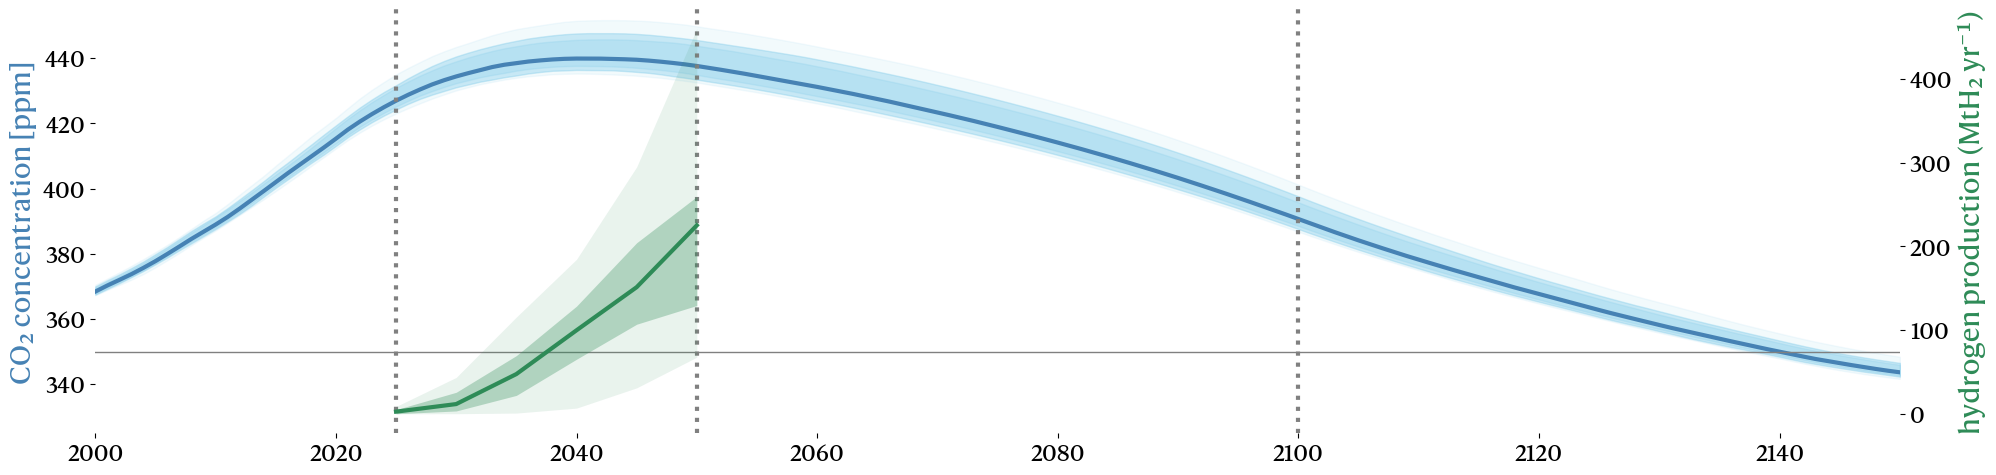

In [30]:
rcParams["ytick.right"] = false
rcParams["xtick.top"] = false
rcParams["xtick.bottom"] = true
rcParams["ytick.direction"] = "out"
rcParams["ytick.minor.visible"] = false
rcParams["xtick.direction"] = "out"
rcParams["xtick.minor.visible"] = false
rcParams["figure.facecolor"] = "white"
                
font_prop_ticks° = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=16);
font_prop_ticks°1 = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=20);
font_prop_titles° = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=11, weight="bold");
font_prop_labels° = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=10);
font_prop_legend° = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=6);

fig,ax= plt.subplots(figsize=(20,5))
colr="skyblue"
CO2_concq50.sel(timebounds=2000:1:2150).plot(ax=ax, label="FaIR: SSP1-19", color="steelblue",lw=3)
ax.fill_between(2000:1:2150, CO2_concmin.sel(timebounds=2000:1:2150), CO2_concmax.sel(timebounds=2000:1:2150), alpha=0.1, color=colr)
ax.fill_between(2000:1:2150, CO2_concq05.sel(timebounds=2000:1:2150), CO2_concq95.sel(timebounds=2000:1:2150), alpha=0.4, color=colr)
ax.fill_between(2000:1:2150, CO2_concq16.sel(timebounds=2000:1:2150), CO2_concq84.sel(timebounds=2000:1:2150), alpha=0.25, color=colr)
ax.axvline(2100, ls=":", color="grey", linewidth=3)
ax.axvline(2025, ls=":", color="grey", linewidth=3)
ax.axvline(2050, ls=":", color="grey", linewidth=3)
ax.axhline(350, color="grey",linewidth=1)
# ax.axhline(450, color="goldenrod",linewidth=1)
ax.set_frame_on(false)
# ax.set_yticks([])
ax.set_ylim(325, 455)

ax.set_xlabel("")

ax2= ax.twinx()
ax2.plot(years,ṁᴹᵗq50,linewidth=3,color="seagreen",label="Model ensemble")
ax2.fill_between(x=years, y1=ṁᴹᵗq05, y2=ṁᴹᵗq95, color="seagreen",linewidth=0, alpha=0.1) #85% proba
ax2.fill_between(x=years, y1=ṁᴹᵗq25, y2=ṁᴹᵗq75, color="seagreen",linewidth=0, alpha=0.3) #70% proba
ax.set_xlim(2000, 2150)
ax2.set_frame_on(false)

ax.annotate("", xy=(100, 400), xytext=(0, 0),
            arrowprops=Dict("arrowstyle"=>"->"))
            ax

for ticklabel in ax.get_xticklabels()
    ticklabel.set_fontproperties(font_prop_ticks°)
end
for ticklabel in ax.get_yticklabels()
    ticklabel.set_fontproperties(font_prop_ticks°)
end
for ticklabel in ax2.get_yticklabels()
    ticklabel.set_fontproperties(font_prop_ticks°)
end

ax.set_ylabel("CO₂ concentration [ppm]",fontproperties=font_prop_ticks°1,color="steelblue")
ax2.set_ylabel("hydrogen production (MtH₂ yr⁻¹)",fontproperties=font_prop_ticks°1,color="seagreen")

fig.tight_layout()
ax.set_title("")
fig.savefig("./Source data/02_results/Fig1/"*"co2_concentration.svg", bbox_inches="tight",transparent=true)
display(fig)
plt.close("all")
